<a href="https://colab.research.google.com/github/rajivsam/cmi_count_data_modeling/blob/asif_ikbal_06_09_2021/notebooks/retail_DecesionTreeRegressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 'poisson' criterion added in DecesionTreeRegressor after sklearn version 0.24
!pip uninstall scikit-learn -y
!pip install -U scikit-learn

Found existing installation: scikit-learn 0.22.2.post1
Uninstalling scikit-learn-0.22.2.post1:
  Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 22.3 MB 20.6 MB/s 


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_poisson_deviance
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from tabulate import tabulate
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import plot_tree
import graphviz

# Loading the data set for quarter 1

In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/rajivsam/cmi_count_data_modeling/main/data/Q1_transform_hourly_arrivals_dataset.csv')

In [4]:
data

,h,arr(h-28),arr(h-26),arr(h-25),arr(h-21),arr(h-20),arr(h-19),arr(h-18),arr(h-17),arr(h-14),arr(h-13),arr(h-12),arr(h-11),arr(h-10),arr(h-9),arr(h-7),arr(h-6),arr(h-5),arr(h-4),arr(h-3),arr(h-2),arr(h-1),Day,Week,Month,arr(h)
0,06:00:00,0.0,0.0,0.0,7.0,6.0,5.0,1.0,0.0,0.0,0.0,0.0,3.0,6.0,7.0,8.0,1.0,5.0,3.0,1.0,0.0,0.0,Thursday,1,1,0.0
1,07:00:00,0.0,0.0,6.0,6.0,5.0,1.0,0.0,0.0,0.0,0.0,3.0,6.0,7.0,12.0,1.0,5.0,3.0,1.0,0.0,0.0,0.0,Thursday,1,1,0.0
2,08:00:00,0.0,6.0,5.0,5.0,1.0,0.0,0.0,0.0,0.0,3.0,6.0,7.0,12.0,8.0,5.0,3.0,1.0,0.0,0.0,0.0,0.0,Thursday,1,1,1.0
3,09:00:00,0.0,5.0,5.0,1.0,0.0,0.0,0.0,0.0,3.0,6.0,7.0,12.0,8.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,Thursday,1,1,3.0
4,10:00:00,6.0,5.0,7.0,0.0,0.0,0.0,0.0,0.0,6.0,7.0,12.0,8.0,1.0,5.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,Thursday,1,1,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1031,15:00:00,7.0,1.0,0.0,0.0,5.0,5.0,9.0,6.0,4.0,3.0,5.0,2.0,5.0,0.0,2.0,5.0,9.0,11.0,8.0,11.0,8.0,Friday,13,4,3.0
1032,16:00:00,4.0,0.0,0.0,5.0,5.0,9.0,6.0,12.0,3.0,5.0,2.0,5.0,0.0,0.0,5.0,9.0,11.0,8.0,11.0,8.0,3.0,Friday,13,4,3.0
1033,17:00:00,1.0,0.0,0.0,5.0,9.0,6.0,12.0,2.0,5.0,2.0,5.0,0.0,0.0,2.0,9.0,11.0,8.0,11.0,8.0,3.0,3.0,Friday,13,4,0.0
1034,18:00:00,0.0,0.0,0.0,9.0,6.0,12.0,2.0,4.0,2.0,5.0,0.0,0.0,2.0,5.0,11.0,8.0,11.0,8.0,3.0,3.0,0.0,Friday,13,4,0.0


# Encoding categorical variables
- 1 hour time interval between h:00:00 and (h+1):00:00 is represented by h:00:00 in the 'h' column. Converting it into 'h'.
- Mapping weekday names to 0 to 6 starting from Sunday.

In [5]:
data['h']=[int(t.split(':')[0]) for t in data['h']]

In [6]:
days = {'Sunday':0,'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6}
data['Day']=[days[d] for d in data['Day']]

In [7]:
data

,h,arr(h-28),arr(h-26),arr(h-25),arr(h-21),arr(h-20),arr(h-19),arr(h-18),arr(h-17),arr(h-14),arr(h-13),arr(h-12),arr(h-11),arr(h-10),arr(h-9),arr(h-7),arr(h-6),arr(h-5),arr(h-4),arr(h-3),arr(h-2),arr(h-1),Day,Week,Month,arr(h)
0,6,0.0,0.0,0.0,7.0,6.0,5.0,1.0,0.0,0.0,0.0,0.0,3.0,6.0,7.0,8.0,1.0,5.0,3.0,1.0,0.0,0.0,4,1,1,0.0
1,7,0.0,0.0,6.0,6.0,5.0,1.0,0.0,0.0,0.0,0.0,3.0,6.0,7.0,12.0,1.0,5.0,3.0,1.0,0.0,0.0,0.0,4,1,1,0.0
2,8,0.0,6.0,5.0,5.0,1.0,0.0,0.0,0.0,0.0,3.0,6.0,7.0,12.0,8.0,5.0,3.0,1.0,0.0,0.0,0.0,0.0,4,1,1,1.0
3,9,0.0,5.0,5.0,1.0,0.0,0.0,0.0,0.0,3.0,6.0,7.0,12.0,8.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,4,1,1,3.0
4,10,6.0,5.0,7.0,0.0,0.0,0.0,0.0,0.0,6.0,7.0,12.0,8.0,1.0,5.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,4,1,1,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1031,15,7.0,1.0,0.0,0.0,5.0,5.0,9.0,6.0,4.0,3.0,5.0,2.0,5.0,0.0,2.0,5.0,9.0,11.0,8.0,11.0,8.0,5,13,4,3.0
1032,16,4.0,0.0,0.0,5.0,5.0,9.0,6.0,12.0,3.0,5.0,2.0,5.0,0.0,0.0,5.0,9.0,11.0,8.0,11.0,8.0,3.0,5,13,4,3.0
1033,17,1.0,0.0,0.0,5.0,9.0,6.0,12.0,2.0,5.0,2.0,5.0,0.0,0.0,2.0,9.0,11.0,8.0,11.0,8.0,3.0,3.0,5,13,4,0.0
1034,18,0.0,0.0,0.0,9.0,6.0,12.0,2.0,4.0,2.0,5.0,0.0,0.0,2.0,5.0,11.0,8.0,11.0,8.0,3.0,3.0,0.0,5,13,4,0.0


# Separating Input features and target variable

In [8]:
X = data.drop(columns=['arr(h)'])
y = data['arr(h)']

# Finding best value for maximum depth in the decesion tree regressor
1. Constructed the tree for a wide range of values for max_depth (1 to 26). There are 26 features in X. So, maximum would be 26.
2. Recorded mean poisson deviance for train and test set for all the trees.
3. plotted mean poisson deviance against max_depth for train and test set.
4. splitted data set 4 times into train and test set. Performed 1-3 for all these 4 train-test sets.

In [9]:
def mean_poisson_deviance_custom(y_true, y_pred):
  for i,x in enumerate(y_pred):
    if x<=0:
      y_pred[i]=0.0001
  return mean_poisson_deviance(y_true,y_pred)

In [10]:
def dtr_dev(i=0,max_depth=10):
  regressor = DecisionTreeRegressor(criterion='poisson',random_state=i,max_depth=max_depth)
  regressor.fit(split_data[i]['X_train'],split_data[i]['y_train'])
  y_train_pred = regressor.predict(split_data[i]['X_train'])
  y_test_pred = regressor.predict(split_data[i]['X_test'])
  return mean_poisson_deviance_custom(split_data[i]['y_train'],y_train_pred), mean_poisson_deviance_custom(split_data[i]['y_test'],y_test_pred)

In [11]:
def dev_matrix(i=0):
  mat = []
  for k in range(1,27):
    dev_train,dev_test=dtr_dev(i,max_depth=k)
    mat.append([k,dev_train,dev_test])
  headers = ['max_depth','dev_train','dev_test']
  table = tabulate(mat, headers, tablefmt="fancy_grid")
  print(table)
  return mat

In [12]:
def plot_dev(mat):
  mat= np.matrix(mat)
  depth = mat[:,0]
  dev_train_ = mat[:,1]
  dev_test_ = mat[:,2]
  plt.subplot(2,2,i+1)
  plt.tight_layout()
  plt.plot(depth,dev_train_,label='Train Deviance')
  plt.plot(depth,dev_test_,label='Test Deviance')
  plt.grid(True)
  plt.legend(frameon=False)

In [13]:
split_data=[]
for i in range(4):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=i)
  split_data.append({'X_train':X_train, 'X_test':X_test, 'y_train':y_train, 'y_test':y_test})

In [14]:
split_data[0]['X_train'].shape,split_data[0]['y_train'].shape , split_data[0]['X_test'].shape, split_data[0]['y_test'].shape

((690, 25), (690,), (346, 25), (346,))

In [15]:
split_data[0]['X_train']

,h,arr(h-28),arr(h-26),arr(h-25),arr(h-21),arr(h-20),arr(h-19),arr(h-18),arr(h-17),arr(h-14),arr(h-13),arr(h-12),arr(h-11),arr(h-10),arr(h-9),arr(h-7),arr(h-6),arr(h-5),arr(h-4),arr(h-3),arr(h-2),arr(h-1),Day,Week,Month
947,15,9.0,1.0,0.0,3.0,8.0,6.0,6.0,9.0,3.0,3.0,1.0,5.0,1.0,0.0,4.0,1.0,7.0,6.0,10.0,4.0,9.0,5,12,3
523,11,8.0,8.0,7.0,0.0,0.0,0.0,0.0,3.0,4.0,12.0,5.0,9.0,3.0,3.0,0.0,3.0,0.0,0.0,2.0,3.0,7.0,5,7,2
466,10,6.0,7.0,4.0,1.0,0.0,0.0,0.0,0.0,1.0,4.0,5.0,3.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,1,7,2
285,11,3.0,8.0,7.0,1.0,1.0,0.0,0.0,0.0,2.0,8.0,6.0,5.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0,5,1
420,6,0.0,0.0,2.0,3.0,5.0,6.0,1.0,1.0,0.0,0.0,0.0,1.0,5.0,3.0,4.0,3.0,2.0,1.0,0.0,0.0,0.0,4,6,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,17,4.0,0.0,0.0,6.0,3.0,8.0,8.0,7.0,1.0,1.0,1.0,0.0,0.0,0.0,7.0,2.0,8.0,6.0,5.0,5.0,2.0,5,4,1
763,13,5.0,5.0,3.0,0.0,0.0,4.0,4.0,4.0,4.0,6.0,4.0,0.0,0.0,0.0,0.0,2.0,3.0,4.0,9.0,3.0,8.0,4,10,3
835,15,6.0,0.0,0.0,2.0,3.0,5.0,4.0,10.0,4.0,3.0,0.0,0.0,0.0,0.0,2.0,5.0,3.0,9.0,7.0,5.0,8.0,3,11,3
559,19,0.0,0.0,0.0,4.0,6.0,5.0,3.0,0.0,0.0,0.0,0.0,2.0,5.0,6.0,4.0,4.0,3.0,3.0,0.0,2.0,0.0,1,8,2


In [16]:
split_data[1]['X_train']

,h,arr(h-28),arr(h-26),arr(h-25),arr(h-21),arr(h-20),arr(h-19),arr(h-18),arr(h-17),arr(h-14),arr(h-13),arr(h-12),arr(h-11),arr(h-10),arr(h-9),arr(h-7),arr(h-6),arr(h-5),arr(h-4),arr(h-3),arr(h-2),arr(h-1),Day,Week,Month
623,13,3.0,7.0,4.0,0.0,0.0,2.0,3.0,8.0,8.0,4.0,5.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,5.0,9.0,5.0,0,9,2
0,6,0.0,0.0,0.0,7.0,6.0,5.0,1.0,0.0,0.0,0.0,0.0,3.0,6.0,7.0,8.0,1.0,5.0,3.0,1.0,0.0,0.0,4,1,1
472,16,1.0,0.0,0.0,0.0,1.0,4.0,5.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,8.0,3.0,3.0,7.0,3.0,6.0,6.0,1,7,2
788,10,9.0,8.0,6.0,0.0,0.0,1.0,0.0,0.0,4.0,4.0,8.0,5.0,8.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,11,3
323,7,0.0,5.0,5.0,8.0,9.0,3.0,0.0,0.0,0.0,2.0,3.0,8.0,10.0,7.0,7.0,5.0,3.0,0.0,0.0,0.0,0.0,3,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
960,14,6.0,3.0,1.0,0.0,4.0,1.0,7.0,6.0,9.0,4.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,6.0,4.0,4.0,0,13,3
847,13,4.0,4.0,3.0,0.0,0.0,2.0,5.0,3.0,5.0,8.0,5.0,2.0,0.0,0.0,0.0,1.0,0.0,5.0,6.0,1.0,8.0,4,11,3
715,7,0.0,4.0,6.0,6.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,6.0,6.0,6.0,2.0,0.0,0.0,0.0,0.0,0.0,1,10,3
905,15,8.0,0.0,0.0,3.0,3.0,6.0,8.0,8.0,6.0,3.0,1.0,0.0,0.0,0.0,2.0,2.0,2.0,5.0,9.0,7.0,3.0,2,12,3


In [17]:
dev_mat=[]
for i in range(4):
  print('Table for Random state '+str(i))
  dev_mat.append(dev_matrix(i))

Table for Random state 0
╒═════════════╤═════════════╤════════════╕
│   max_depth │   dev_train │   dev_test │
╞═════════════╪═════════════╪════════════╡
│           1 │     3.51844 │    3.77846 │
├─────────────┼─────────────┼────────────┤
│           2 │     3.49706 │    3.77412 │
├─────────────┼─────────────┼────────────┤
│           3 │     3.41283 │    3.74128 │
├─────────────┼─────────────┼────────────┤
│           4 │     3.31709 │    3.63119 │
├─────────────┼─────────────┼────────────┤
│           5 │     3.20444 │    3.53884 │
├─────────────┼─────────────┼────────────┤
│           6 │     3.18028 │    3.57408 │
├─────────────┼─────────────┼────────────┤
│           7 │     3.10353 │    3.5253  │
├─────────────┼─────────────┼────────────┤
│           8 │     3.02816 │    3.53103 │
├─────────────┼─────────────┼────────────┤
│           9 │     2.99694 │    3.53425 │
├─────────────┼─────────────┼────────────┤
│          10 │     2.98275 │    3.54827 │
├─────────────┼─────────────┼

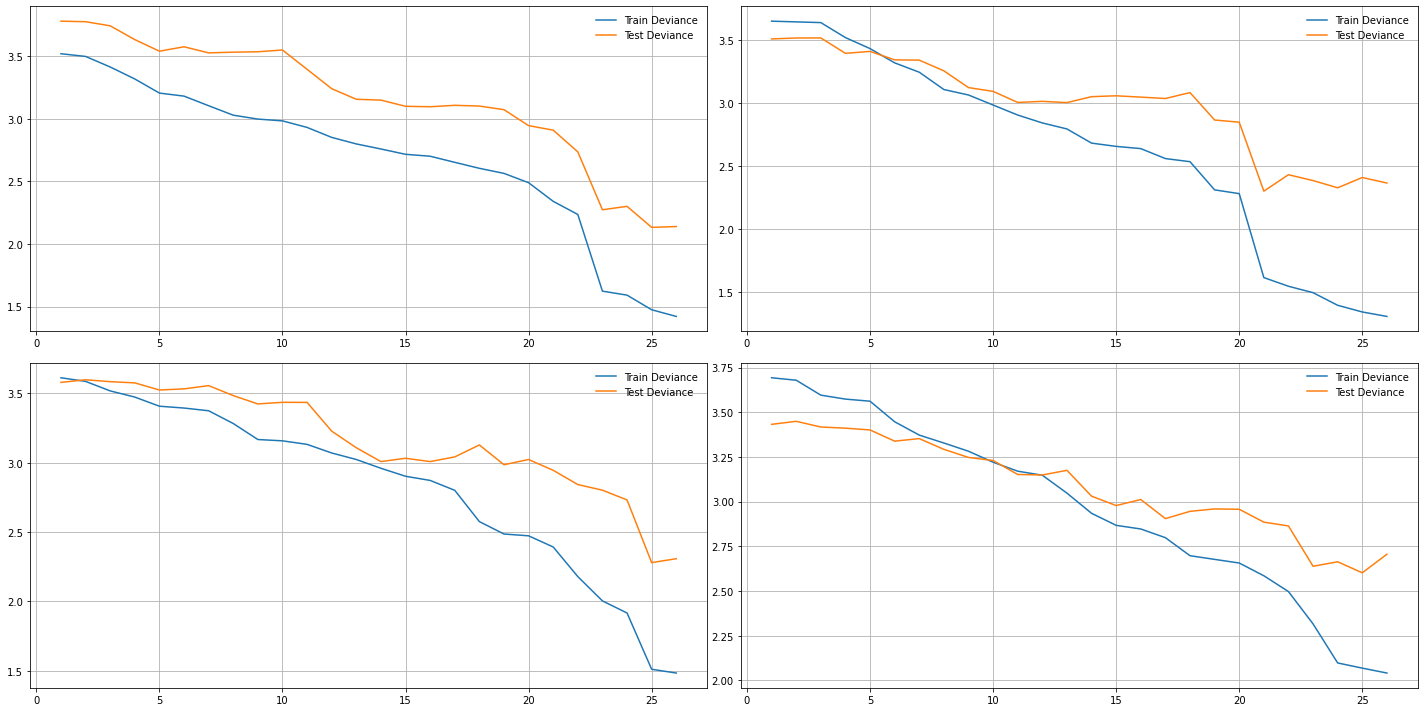

In [18]:
plt.figure(figsize=(20,10))
for i in range(4):
  plot_dev(dev_mat[i])

- Using cross validation score to find optimal value of max_depth

In [19]:
def run_cross_validation_on_trees(X, y, tree_depths, cv=5, scoring='accuracy'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    deviance_scores = []
    for depth in tree_depths:
        tree_model = DecisionTreeRegressor(criterion='poisson',max_depth=depth)
        cv_scores = cross_val_score(tree_model, X, y, cv=cv,scoring=make_scorer(mean_poisson_deviance_custom,greater_is_better=False))
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        deviance_scores.append(mean_poisson_deviance_custom(y,tree_model.fit(X, y).predict(X)))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    deviance_scores = np.array(deviance_scores)
    return -cv_scores_mean, -cv_scores_std, deviance_scores

In [20]:
# function for plotting cross-validation results
def plot_cross_validation_on_trees(depths, cv_scores_mean, cv_scores_std, deviance_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, deviance_scores, '-*', label='train Deviance', alpha=0.9)
    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation Deviance', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('Deviance', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()

In [21]:
def plot_to_find_depth():
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)
  # fitting trees of depth 1 to 24
  sm_tree_depths = range(1,26)
  sm_cv_scores_mean, sm_cv_scores_std, deviance_train = run_cross_validation_on_trees(X_train, y_train, sm_tree_depths)

  # plotting accuracy
  plot_cross_validation_on_trees(sm_tree_depths, sm_cv_scores_mean, sm_cv_scores_std, deviance_train, 
                                'Deviance per decision tree depth on training data')


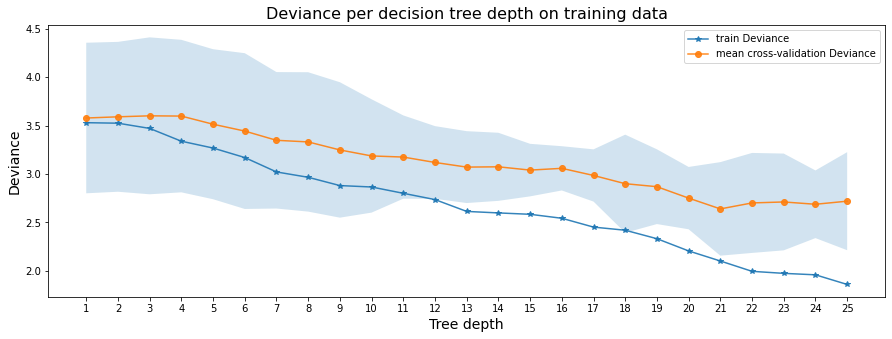

In [22]:
plot_to_find_depth()

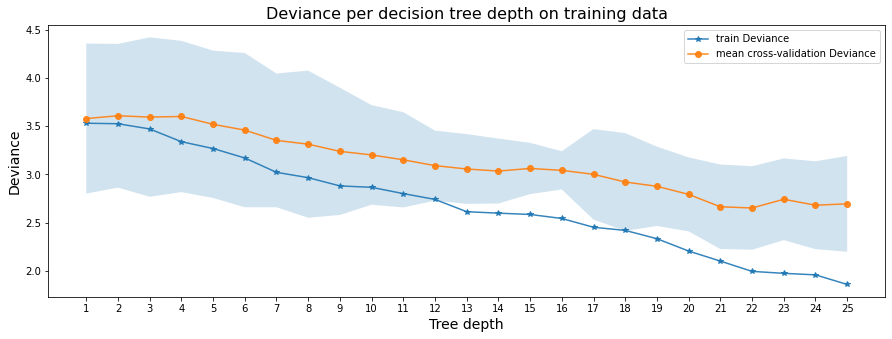

In [23]:
plot_to_find_depth()

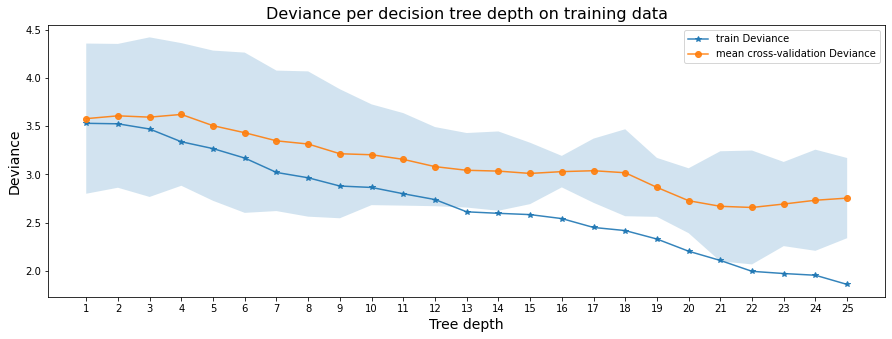

In [24]:
plot_to_find_depth()

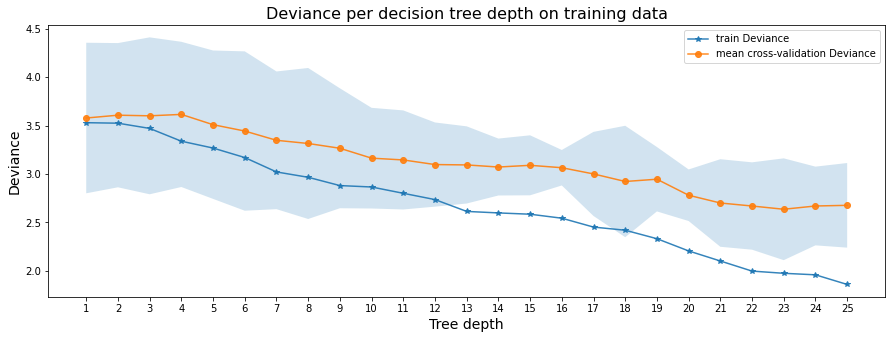

In [25]:
plot_to_find_depth()

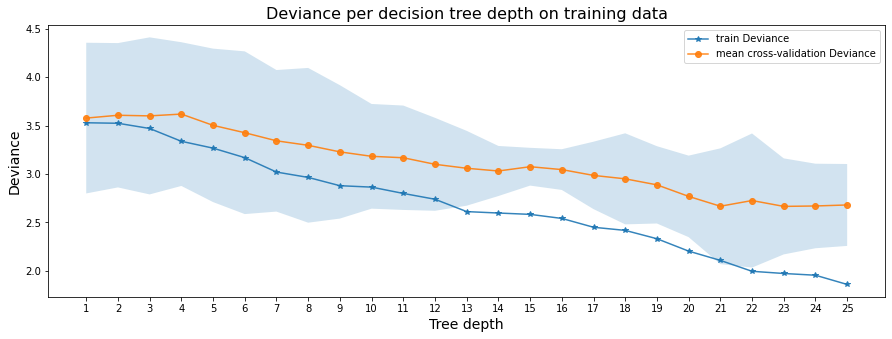

In [26]:
plot_to_find_depth()

- Mean cross validation deviance is minimum for tree depth between 21-23
- Selecting max_depth=21

# Constructing the tree with max_depth=21

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)

In [28]:
regressor = DecisionTreeRegressor(criterion='poisson',max_depth=21)
model = regressor.fit(X_train,y_train)

# Extracting the business rules from the tree

In [29]:
text_representation = tree.export_text(regressor,feature_names=list(X.columns))
print(text_representation)

|--- arr(h-13) <= 13.50
|   |--- arr(h-11) <= 13.50
|   |   |--- arr(h-26) <= 10.50
|   |   |   |--- arr(h-1) <= 9.50
|   |   |   |   |--- arr(h-28) <= 10.50
|   |   |   |   |   |--- arr(h-1) <= 8.50
|   |   |   |   |   |   |--- arr(h-2) <= 9.50
|   |   |   |   |   |   |   |--- arr(h-28) <= 9.50
|   |   |   |   |   |   |   |   |--- arr(h-13) <= 9.50
|   |   |   |   |   |   |   |   |   |--- arr(h-12) <= 13.50
|   |   |   |   |   |   |   |   |   |   |--- arr(h-14) <= 9.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 11
|   |   |   |   |   |   |   |   |   |   |--- arr(h-14) >  9.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 9
|   |   |   |   |   |   |   |   |   |--- arr(h-12) >  13.50
|   |   |   |   |   |   |   |   |   |   |--- value: [6.00]
|   |   |   |   |   |   |   |   |--- arr(h-13) >  9.50
|   |   |   |   |   |   |   |   |   |--- arr(h-1) <= 7.00
|   |   |   |   |   |   |   |   |   |   |--- arr(h-3) <= 3.50
|   |   |   |

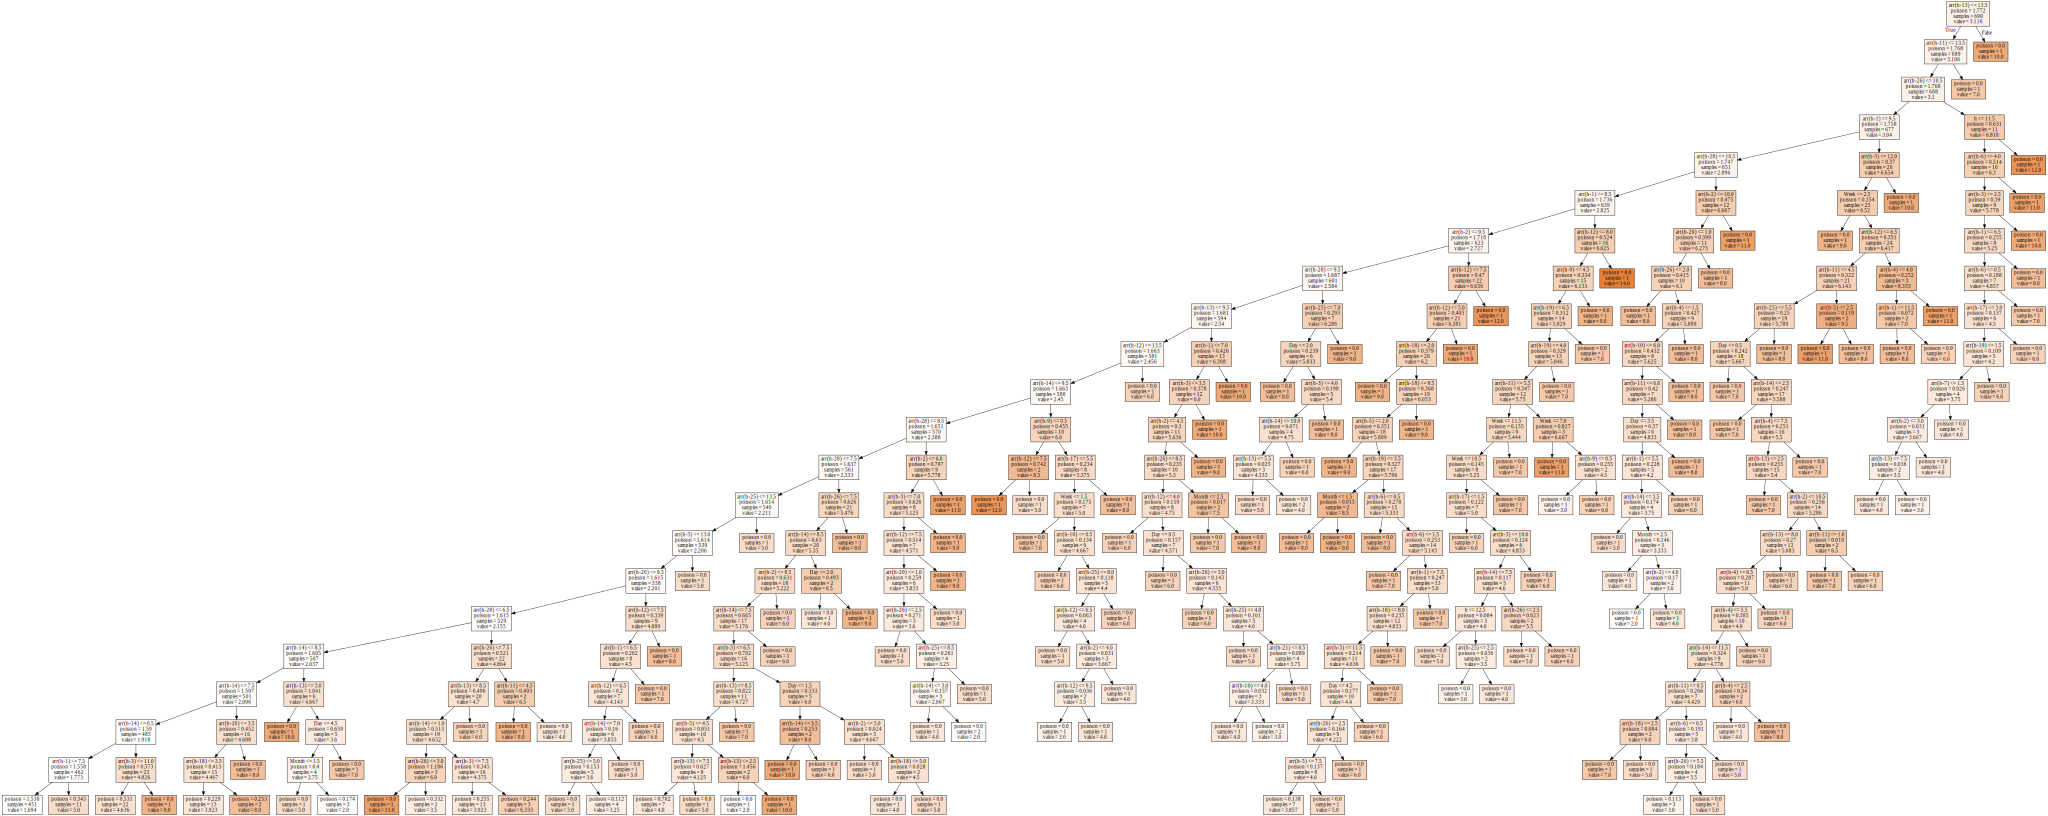

In [30]:
dot_data = tree.export_graphviz(regressor, out_file=None, 
                                feature_names=X.columns,  
                                filled=True)
graphviz.Source(dot_data, format="png") 

In [31]:
def plot_decision_tree(model, feature_names):
    # plot_tree function contains a list of all nodes and leaves of the Decision tree
    tree = plot_tree(model, feature_names = feature_names,filled=True, fontsize=10)
    
    # I return the tree for the next part
    return tree

In [32]:
def plot_decision_path_tree(model, X, class_names=None):
    fig = plt.figure(figsize=(10,30))
    
    feature_names = X.index
    
    # Getting the tree from the function programmed above
    tree = plot_decision_tree(model, feature_names)
    
    # Get the decision path of the wanted prediction 
    decision_path = model.decision_path([X])

    # Now remember the tree object contains all nodes and leaves so the logic here
    # is to loop into the tree and change visible attribute for components that 
    # are not in the decision path
    for i in range(0,len(tree)):
        if i not in decision_path.indices:
            plt.setp(tree[i],visible=False)


In [33]:
y_pred = (regressor.predict(X_test))
most_sample_in_node = X_test[np.array(y_pred<=1.7) & np.array(y_pred>1.6)]

In [34]:
most_sample_in_node

,h,arr(h-28),arr(h-26),arr(h-25),arr(h-21),arr(h-20),arr(h-19),arr(h-18),arr(h-17),arr(h-14),arr(h-13),arr(h-12),arr(h-11),arr(h-10),arr(h-9),arr(h-7),arr(h-6),arr(h-5),arr(h-4),arr(h-3),arr(h-2),arr(h-1),Day,Week,Month
109,17,0.0,0.0,0.0,9.0,6.0,8.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,7.0,4.0,7.0,5.0,5.0,2.0,1.0,5,2,1
458,16,3.0,0.0,2.0,2.0,6.0,8.0,7.0,4.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,5.0,3.0,2.0,4.0,0,7,2
541,15,3.0,2.0,0.0,2.0,3.0,7.0,6.0,6.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,2.0,4.0,6.0,5.0,0,8,2
519,7,0.0,6.0,10.0,7.0,3.0,3.0,0.0,0.0,0.0,3.0,2.0,4.0,4.0,12.0,9.0,3.0,3.0,2.0,0.0,3.0,0.0,5,7,2
101,9,2.0,6.0,7.0,4.0,0.0,0.0,0.0,0.0,4.0,9.0,6.0,8.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
572,18,0.0,0.0,0.0,3.0,4.0,4.0,3.0,3.0,0.0,0.0,0.0,0.0,1.0,6.0,8.0,6.0,6.0,3.0,7.0,3.0,3.0,2,8,2
491,7,0.0,8.0,3.0,6.0,6.0,0.0,0.0,0.0,0.0,1.0,6.0,7.0,7.0,6.0,6.0,6.0,1.0,1.0,0.0,0.0,0.0,3,7,2
527,15,3.0,0.0,0.0,3.0,2.0,4.0,4.0,12.0,3.0,3.0,2.0,0.0,3.0,0.0,2.0,3.0,7.0,6.0,6.0,4.0,2.0,5,7,2
599,17,3.0,0.0,0.0,7.0,2.0,10.0,7.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,6.0,6.0,8.0,3.0,5.0,7.0,4.0,4,8,2


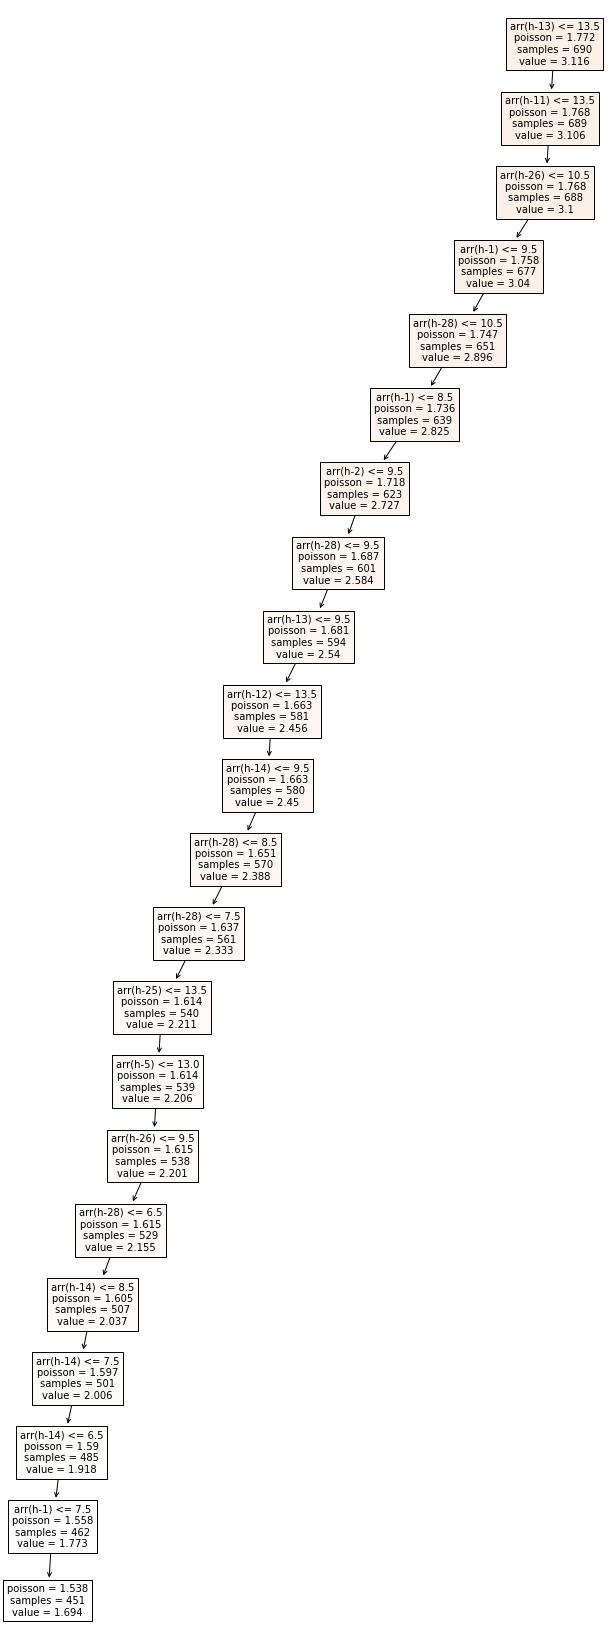

In [35]:
plot_decision_path_tree(regressor, most_sample_in_node.iloc[0,:])

In [36]:
#Performance on test data
dev = mean_poisson_deviance_custom(y_test, regressor.predict(X_test))
print('Mean poisson deviance on test data is '+str(dev))

Mean poisson deviance on test data is 2.9985057615361352
